In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
import matplotlib.patches as patches

def show_boxes(ax, boxes):
    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]),
                             box[2], 
                             box[3],
                             edgecolor='r', facecolor='none', linewidth=3)
        ax.add_patch(rect)

In [9]:
import random
import os
image_file = random.sample(os.listdir("_data/combined/test"), 1)[0]
image = cv2.imread(os.path.join("_data/combined/test", image_file))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

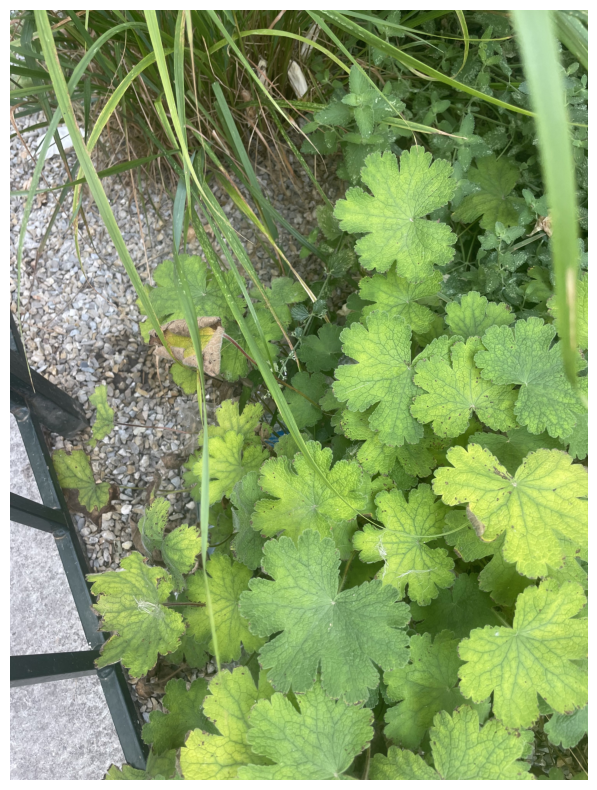

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [11]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

In [12]:
masks = mask_generator.generate(image)

In [13]:
print(len(masks))
print(masks[0].keys())
print(masks[0]["segmentation"])
print(masks[0]["segmentation"].shape, image.shape)

161
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(4032, 3024) (4032, 3024, 3)


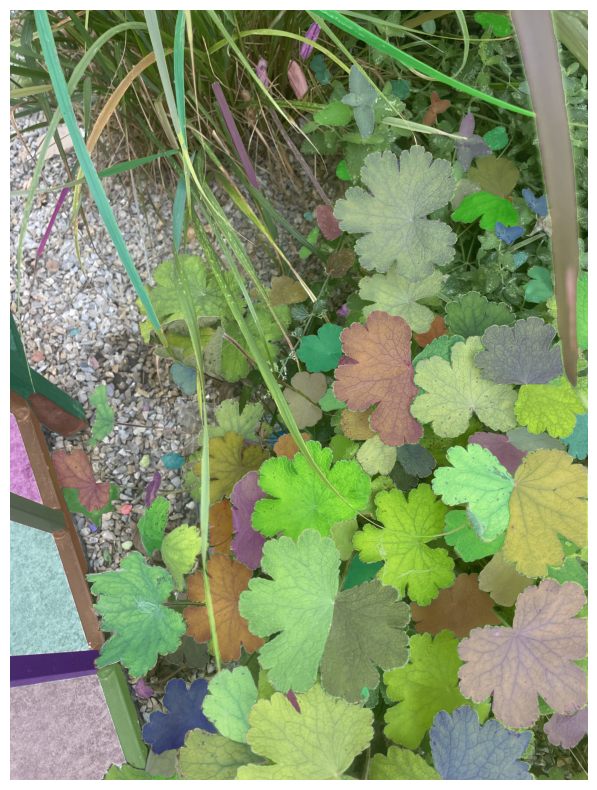

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

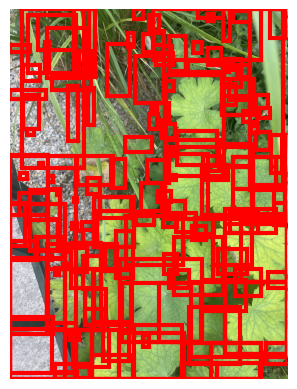

In [15]:
fig, ax = plt.subplots()
ax.imshow(image)
show_boxes(ax, [mask["bbox"] for mask in masks])
plt.axis('off')
plt.show() 

In [16]:
def get_patches(masks, image, apply_mask=False):
    result = []
    
    for mask in masks:
        if apply_mask:
            image_tmp = image * (mask["segmentation"][:, :, np.newaxis])
        else:
            image_tmp = image
        
        bbox = mask["bbox"]
        patch = image_tmp[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
        
        if 0 in patch.shape:
            continue
        result.append(patch)
    
    return result

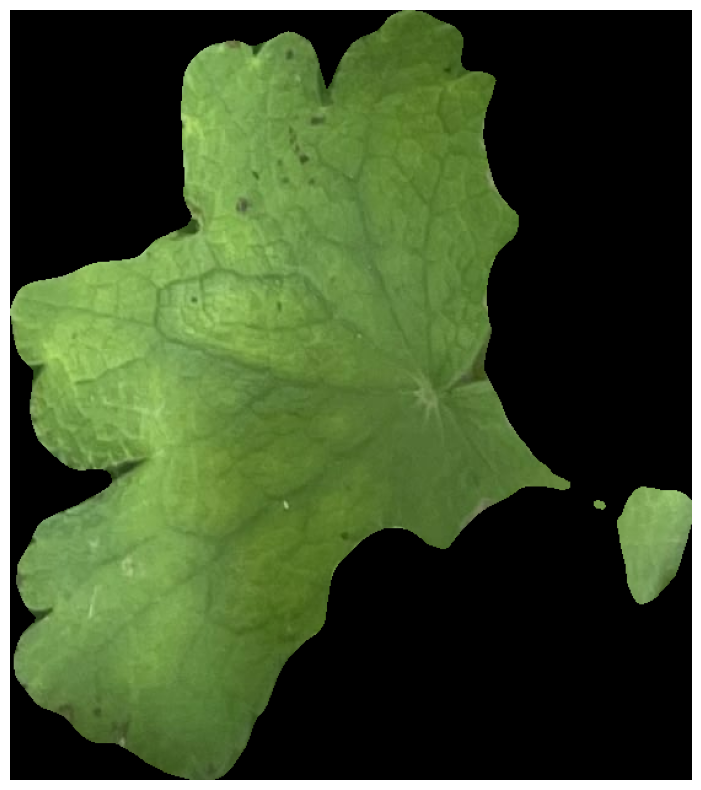

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(get_patches(masks, image, True)[25])
plt.axis('off')
plt.show()

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class SingleClassDataset(Dataset):
    def __init__(self, folder_path, transform=None, apply_mask=False, crop_to_mask=False):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(os.path.join(folder_path, "images")) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.apply_mask = apply_mask
        if apply_mask:
            self.mask_files = [f for f in os.listdir(os.path.join(folder_path, "leaf_instances")) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.crop_to_mask = crop_to_mask

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, "images", self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.apply_mask:
            mask_name = os.path.join(self.folder_path, "leaf_instances", self.mask_files[idx])
            mask = np.asarray(Image.open(mask_name).convert('L'))
            image = np.where(np.dstack([mask] * 3), image, 0)

            if self.crop_to_mask:
                binary_mask = np.any(image != [0, 0, 0], axis=-1)

                # Find the coordinates of the non-black pixels
                non_black_pixels = np.argwhere(binary_mask)

                # Find the bounding box of the non-black pixels
                top_left = np.min(non_black_pixels, axis=0)
                bottom_right = np.max(non_black_pixels, axis=0)
                
                image = image[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
                
            image = Image.fromarray(image)
        
        
        if self.transform:
            image = self.transform(image)
        
        # Since it's a single class, we can use a constant label (e.g., 0)
        label = 0
        
        return image, label

# Usage example:
folder_path = '_data/urban_street0_25'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SingleClassDataset(folder_path, transform=transform)

# Create a DataLoader
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# YOLO detection 

In [41]:
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('foduucom/plant-leaf-detection-and-classification')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

# perform inference
results = model.predict(os.path.realpath(os.path.join("_data", "combined", "test", image_file)))

# observe results
print(results[0].boxes)


image 1/1 /home/stefan.steinheber/bachelor/processing/leaf_segmentation/_data/combined/test/test3.jpg: 640x480 5 Blueberrys, 2 gauavas, 1 apple, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([22., 14., 14., 14., 22., 14., 28., 14.], device='cuda:0')
conf: tensor([0.6934, 0.5878, 0.5857, 0.5853, 0.5585, 0.4639, 0.2858, 0.2625], device='cuda:0')
data: tensor([[1.4180e+03, 2.1964e+03, 2.0904e+03, 3.2700e+03, 6.9341e-01, 2.2000e+01],
        [1.7065e+02, 1.2007e+03, 1.1361e+03, 1.7391e+03, 5.8779e-01, 1.4000e+01],
        [2.0058e+03, 3.3516e+01, 3.0240e+03, 4.8999e+02, 5.8566e-01, 1.4000e+01],
        [9.0139e+02, 7.6179e+02, 1.4239e+03, 1.1691e+03, 5.8530e-01, 1.4000e+01],
        [8.6794e+02, 2.4297e+03, 1.3416e+03, 2.9094e+03, 5.5847e-01, 2.2000e+01],
        [1.7341e+03, 4.2468e+02, 2.4014e+03, 1.1854e+03, 4.6386e-01, 1.4000e+01],
        [1.8935e+03, 1.1829e+

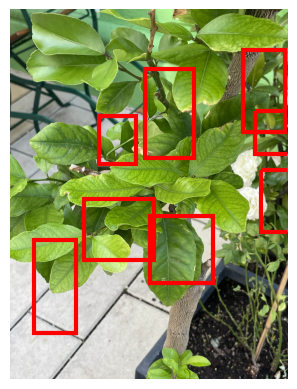

In [42]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(image)
results = results[0].cpu()
for i in range(len(results)):
    rect = patches.Rectangle((results.boxes.xywh[i, 1], results.boxes.xywh[i, 0]),
                             results.boxes.xywh[i, 3], 
                             results.boxes.xywh[i, 2],
                             edgecolor='r', facecolor='none', linewidth=3)
    ax.add_patch(rect)
plt.axis('off')
plt.show() 

# SAM + YOLO detection

In [ ]:
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('foduucom/plant-leaf-detection-and-classification')

# set model parameters
model.overrides['conf'] = 0.8  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

patches = get_patches(masks, image, apply_mask=True)
results = []

for patch in patches:
    # perform inference
    result = model.predict(patch)
    results.append(result[0])

In [47]:
print(len([result for result in results if len(result.boxes) > 0]))

134


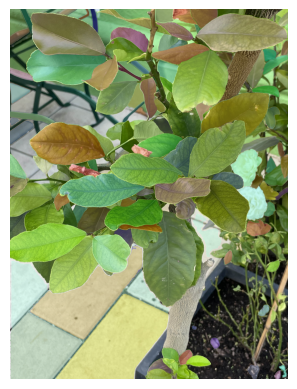

In [48]:
import matplotlib.patches as patches
fig, ax = plt.subplots()
ax.imshow(image)


leaf_masks = [mask for mask, result in zip(masks, results) if len(result.boxes) > 0]

show_anns(leaf_masks)
plt.axis('off')
plt.show() 

# ResNet classification

In [69]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-08-08 11:27:15--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-08-08 11:27:15 (95.1 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [43]:
import torchvision
resnet = torchvision.models.resnet50(pretrained=True)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [71]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [78]:
import torchvision.transforms.v2 as transforms

tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.ToDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),  
])

for mask in masks:
    bbox = mask["bbox"]
    if bbox[2] - bbox[0] == 0 or  bbox[3] - bbox[1] == 0:
        continue
    crop = image[bbox[0]:box[2], bbox[1]:bbox[3], :]
    if crop.shape[0] == 0 or crop.shape[1] == 0:
        continue
    crop = tf(crop)
    crop = crop.unsqueeze(0)
    crop = crop.to(device)
    result = resnet(crop)
    probabilities = torch.nn.functional.softmax(result[0], dim=0)
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 1)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
#    print(result)

bucket 0.005732938647270203
bucket 0.005762018729001284
hook 0.005975078325718641
bucket 0.005998572334647179


# Isolation forest detection

In [17]:
import torch
from torch.utils.data import DataLoader
from pyod.models.iforest import IForest
import numpy as np

# Initialize and fit the Isolation Forest model
clf = IForest(contamination=0.1)  # Adjust contamination as needed
clf.fit(dataset)

# Get the outlier scores
outlier_scores = clf.decision_function(X)

# Get binary labels (0 for inliers, 1 for outliers)
outlier_labels = clf.predict(X)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3261, 2) + inhomogeneous part.

# Autoencoder leaf-detection

## Training

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [7]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=2),  # 112x112
            act_fn,
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2),  # 56x56
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2),  # 28x28
            act_fn,
            nn.Conv2d(4*out_channels, 8*out_channels, 3, padding=1, stride=2),  # 14x14
            act_fn,
            nn.Conv2d(8*out_channels, 16*out_channels, 3, padding=1, stride=2),  # 7x7
            act_fn,
            nn.Flatten(),
            nn.Linear(16*out_channels*7*7, latent_dim),
            act_fn
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.out_channels = out_channels
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 16*out_channels*7*7),
            act_fn
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(16*out_channels, 8*out_channels, 3, stride=2, padding=1, output_padding=1),  # 14x14
            act_fn,
            nn.ConvTranspose2d(8*out_channels, 4*out_channels, 3, stride=2, padding=1, output_padding=1),  # 28x28
            act_fn,
            nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, stride=2, padding=1, output_padding=1),  # 56x56
            act_fn,
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, stride=2, padding=1, output_padding=1),  # 112x112
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, stride=2, padding=1, output_padding=1),  # 224x224
        )

    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 16*self.out_channels, 7, 7)
        output = self.conv(output)
        return output

#  defining autoencoder
class BigAutoencoder(nn.Module):
    def __init__(self, encoder=Encoder(), decoder=Decoder()):
        super().__init__()
        self.encoder = encoder
#        self.encoder.to(device)

        self.decoder = decoder
#        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = SingleClassDataset('_data/us_leaf_d', transform=transform, apply_mask=True, crop_to_mask=True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=16)

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([224, 224, 3])


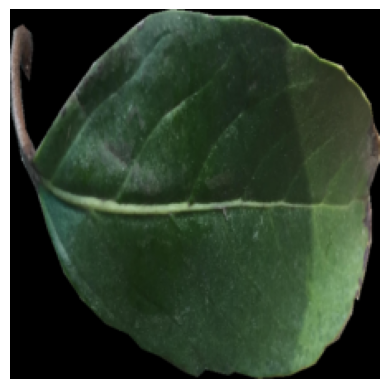

In [23]:
sample, _ = next(iter(dataloader))
sample = torch.permute(sample[0], (1, 2, 0))
print(sample.shape)
plt.imshow(sample)
plt.axis('off')
plt.show()

In [24]:
model = BigAutoencoder()
#model = torch.load("out/autoencoder_latest.pth")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

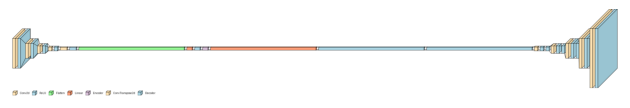

True

In [25]:
import matplotlib.pyplot as plt

import visualtorch
img = visualtorch.layered_view(model, input_shape=(1, 3, 224, 224), legend=True)

plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

cv2.imwrite("out/structure.png", np.array(img))

In [26]:
model.to(device)

BigAutoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=12544, out_features=200, bias=True)
      (12): ReLU()
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=200, out_features=12544, bias=True)
      (1): ReLU()
    )
    (conv): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(128

In [27]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
              ReLU-2         [-1, 16, 112, 112]               0
            Conv2d-3           [-1, 32, 56, 56]           4,640
              ReLU-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 28, 28]          18,496
              ReLU-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 14, 14]          73,856
              ReLU-8          [-1, 128, 14, 14]               0
            Conv2d-9            [-1, 256, 7, 7]         295,168
             ReLU-10            [-1, 256, 7, 7]               0
          Flatten-11                [-1, 12544]               0
           Linear-12                  [-1, 200]       2,509,000
             ReLU-13                  [-1, 200]               0
          Encoder-14                  [

In [ ]:
print("starting training")
# Training loop
num_epochs = 0
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)  # Move input data to GPU
        
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    torch.save(model, "out/autoencoder_latest.pth")

# Save the model
torch.save(model.state_dict(), 'autoencoder_model.pth')

starting training


In [55]:
print("Starting Training")
num_epochs = 20
for epoch in range(num_epochs):
    data_iter = iter(dataloader)

    next_batch = next(data_iter) # start loading the first batch
    next_batch = [ _.cuda(non_blocking=True) for _ in next_batch ]  # with pin_memory=True and non_blocking=True, this will copy data to GPU non blockingly

    for i in range(len(dataloader)):
        batch = next_batch 
        if i + 2 != len(dataloader): 
            # start copying data of next batch
            next_batch = next(data_iter)
            next_batch = [ _.cuda(non_blocking=True) for _ in next_batch]

        # training code
        #batch = [data for data, _ in batch]
        
        recon = model(batch[0])
        loss = criterion(recon, batch[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    torch.save(model, "out/autoencoder_latest.pth")

Starting Training
Epoch [1/20], Loss: 0.0053


KeyboardInterrupt: 

## Testing the trained model

In [23]:
import one_class_detection
import importlib
importlib.reload(one_class_detection)
ae = one_class_detection.Autoencoder(model)
ae.test()

{'accuracy': 0.7083333333333334,
 'precision': 0.7303975200583515,
 'recall': 0.7083333333333334,
 'f1_score': 0.6985788649345863}

In [35]:
# Function to compute anomaly score
def anomaly_score(img):
    model.eval()
    with torch.no_grad():
        img = img.to(device)  # Move input to GPU
        recon = model(img.unsqueeze(0))
        return nn.MSELoss()(recon, img.unsqueeze(0)).item()

In [36]:
# Example usage
from PIL import Image

test_tensor = transform(Image.fromarray(image)).to(device)  # Move test tensor to GPU
score = anomaly_score(test_tensor)
print(f'Anomaly score: {score}')

Anomaly score: 0.03849826008081436


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030659005..0.80810165].


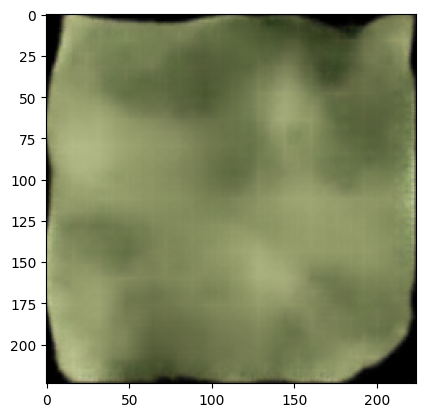

In [37]:
model.eval()
with torch.no_grad():
    recon = model(transform(Image.fromarray(image)).unsqueeze(0).to(device))
    plt.imshow(recon.cpu().numpy().squeeze().transpose((1, 2, 0)))
    plt.show()

## Inference 

In [9]:
#model = torch.load("out/autoencoder_model.pth")
model = torch.load("out/autoencoder_latest.pth")
model.to(device)

/tmp/ipykernel_478319/2304852818.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("out/autoencoder_latest.pth")


BigAutoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=12544, out_features=200, bias=True)
      (12): ReLU()
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=200, out_features=12544, bias=True)
      (1): ReLU()
    )
    (conv): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(128

In [52]:
model.eval()
patches = get_patches(masks, image, True)
results = []
with torch.no_grad():
    for patch in patches:
        #result = model(transform(Image.fromarray(patch)).unsqueeze(0).to(device))
        results.append(anomaly_score(transform(Image.fromarray(patch))))

In [53]:
print(results)

[0.010771065950393677, 0.01487906463444233, 0.02022959105670452, 0.014664539135992527, 0.018378950655460358, 0.022761110216379166, 0.011428783647716045, 0.04956831783056259, 0.012767584063112736, 0.017550144344568253, 0.0053255874663591385, 0.015174182131886482, 0.006195089779794216, 0.021010883152484894, 0.018161237239837646, 0.003024713834747672, 0.004100357182323933, 0.015490272082388401, 0.008744707331061363, 0.021372539922595024, 0.009000622667372227, 0.007966321893036366, 0.007850716821849346, 0.0029691513627767563, 0.010075528174638748, 0.007056227419525385, 0.010519761592149734, 0.011137392371892929, 0.016243888065218925, 0.008916210383176804, 0.017665209248661995, 0.006666841916739941, 0.006141393445432186, 0.011291373521089554, 0.0056091188453137875, 0.003880304517224431, 0.004439832642674446, 0.016750449314713478, 0.0035008492413908243, 0.006945065688341856, 0.002668553963303566, 0.005450604949146509, 0.02132156863808632, 0.003985960967838764, 0.004843323025852442, 0.0023739

Detected leaf masks: 44


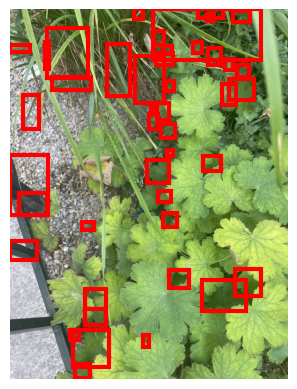

In [54]:
import matplotlib.patches as patches

ANOMALY_THRESHOLD = 0.004
masks_filtered = [mask for mask, result in zip(masks,results) if result < ANOMALY_THRESHOLD]
print("Detected leaf masks:", len(masks_filtered))
fig, ax = plt.subplots()
ax.imshow(image)
show_boxes(ax, [mask["bbox"] for mask in masks_filtered])
plt.axis('off')
plt.show() 